# Pendulum on Cart System with MPC Control

In this notebook, we will simulate a pendulum on a cart system and control it using a Model Predictive Controller (MPC). The goal is to bring the pendulum from a hanging down position to an upright position.

## 1. Define the Pendulum System

First, we will define the pendulum system with friction and the given model.


In [2]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from openmpc.models import NonlinearSystem 
from openmpc.mpc import  MPCProblem, NMPC

# Define the pendulum system with friction and given model
def pendulum_system():
    # Pendulum parameters
    m = 0.2
    b = 0.1
    l = 0.3
    I = 0.006
    g = 9.81

    a = m * g * l / (I + m * l**2)
    c = m * l / (I + m * l**2)

    th = ca.MX.sym("th")
    thDot = ca.MX.sym("thDot")
    u = ca.MX.sym("u")  # Control input

    states = ca.vertcat(th, thDot)
    inputs = ca.vertcat(u)

    # Pendulum dynamics with friction term
    rhs = ca.vertcat(
        thDot,                     # dth/dt
        a * ca.sin(th) + c * ca.cos(th) * u - b * thDot  # dth_dot/dt
    )

    return states, inputs, rhs

# Create the NonlinearSystem object
states, inputs, rhs = pendulum_system()

dt = 0.1
nlsys_pendulum = NonlinearSystem.c2d(updfcn=rhs, states=states, inputs=inputs,dt = dt)

## 2. Define the MPC Problem

Next, we will define the MPC problem data, including the prediction model, cost matrices, horizon, and input/output constraints.


In [3]:
# Create an MP problem
mpc_parameters = MPCProblem( system  = nlsys_pendulum, 
                                horizon = 20, 
                                Q       = np.eye(2), 
                                R       = np.eye(1), 
                                QT      = np.eye(2)*1000)

# set the magnitude constraints
mpc_parameters.add_input_magnitude_constraint(10.)
mpc_parameters.add_output_magnitude_constraint(10.)
mpc_controller = NMPC(mpc_params=mpc_parameters)

## 4. Simulate the System with MPC Control

Next, we simulate the pendulum system with the MPC controller to bring it from hanging down to standing up.


In [4]:
# Simulation parameters
x0      = np.array([np.pi, 0])
Tsim    = 10.0  # Total simulation time
N_steps = int(Tsim /0.1)
time    = np.linspace(0, Tsim, N_steps + 1)

# Initialize arrays to store the simulation results
x_sim = np.zeros((2, N_steps + 1))
u_sim = np.zeros(N_steps)

# Set initial state
x_sim[:, 0] = x0

# Simulation loop
for k in range(N_steps):
    # Compute the control input using MPC
    u_sim[k] = mpc_controller.get_control_action(x_sim[:, k])[0]
    
    # Apply the control input to the system
    x_sim[:, k + 1] = nlsys_pendulum.discrete_dynamics(x_sim[:, k], u_sim[k])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



## 5. Plot the results

Finally, we plot the results.


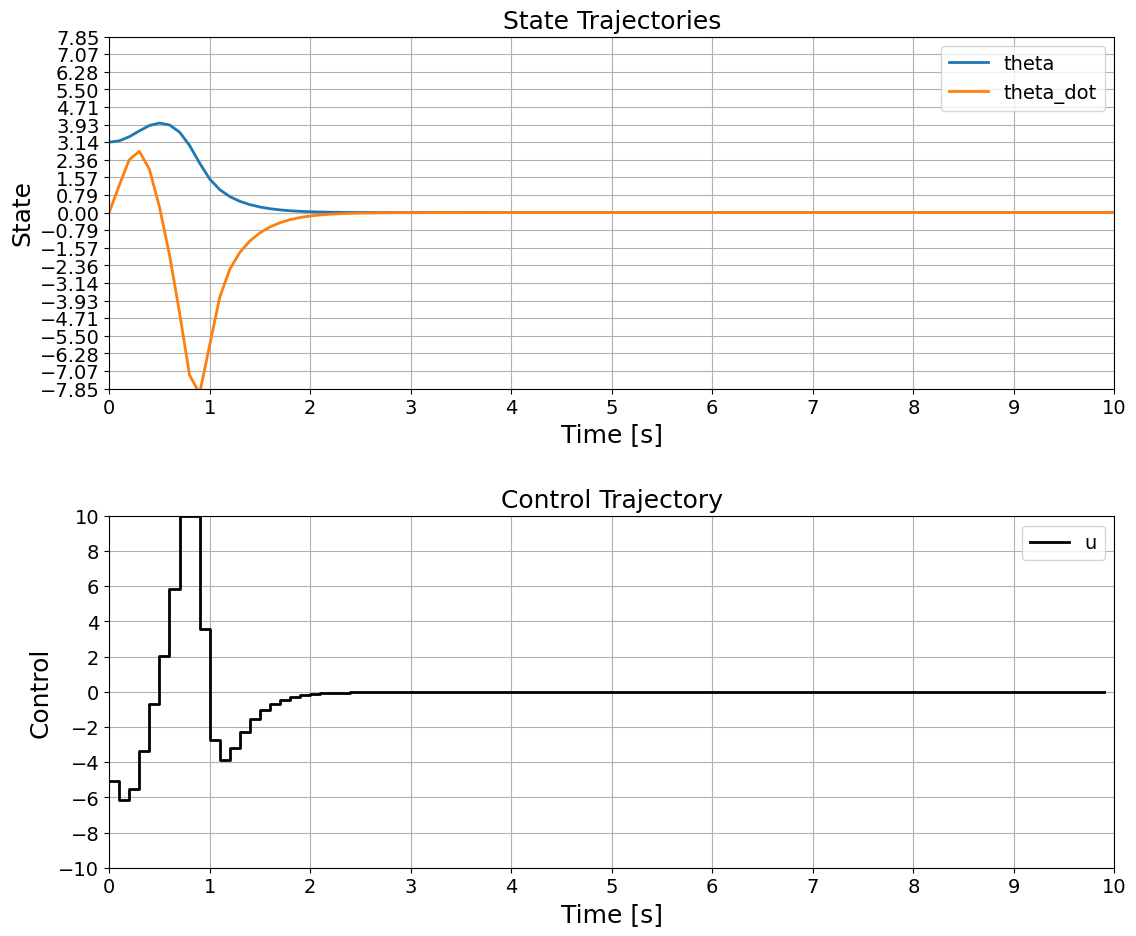

In [5]:

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the state trajectories on the first subplot
ax1.plot(time, x_sim[0, :], label='theta', linewidth=2)
ax1.plot(time, x_sim[1, :], label='theta_dot', linewidth=2)
ax1.set_xlabel('Time [s]', fontsize=18)
ax1.set_ylabel('State', fontsize=18)
ax1.set_xlim([0, Tsim])
ax1.set_ylim([-2.5 * np.pi, 2.5 * np.pi])
ax1.legend(fontsize=14)
ax1.set_title('State Trajectories', fontsize=18)
ax1.grid(True)

# Set grid steps
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(np.pi / 4))

# Plot the control trajectory on the second subplot
ax2.step(time[:-1], u_sim, 'k', label='u', where='post', linewidth=2)
ax2.set_xlabel('Time [s]', fontsize=18)
ax2.set_ylabel('Control', fontsize=18)
ax2.set_xlim([0, Tsim])
ax2.set_ylim([-10, 10])
ax2.legend(fontsize=14)
ax2.set_title('Control Trajectory', fontsize=18)
ax2.grid(True)

# Set grid steps
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(2))

# Set tick font size
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Adjust layout to make space for larger labels
plt.tight_layout(pad=3.0)


# Show the plots
plt.show()